In [14]:
import pandas as pd
import os
import numpy as np

# Cleaning
import re
import emoji
import string
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
seed_value = 42

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#Logistic regression
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression #Prediction Model
from sklearn.metrics import accuracy_score #Comparison between real and predicted

#Random Forest
from sklearn.ensemble import RandomForestClassifier

#SVM
from sklearn.svm import SVC

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [3]:
os.getcwd()

'C:\\Users\\mamai\\Desktop\\Tesi\\Code\\notebookFinaliprove'

In [6]:
def merge_csv(input1, input2, input3, input4):
    path = 'C:\\Users\\mamai\\Desktop\\Tesi\\Code\\twitter download\\'
    path1 = path + input1
    path2 = path + input2
    path3 = path + input3
    path4 = path + input4
    data1 = pd.read_csv(path1)
    data2 = pd.read_csv(path2)
    data3 = pd.read_csv(path3)
    data4 = pd.read_csv(path4)
    output_data = pd.concat([data1,data2,data3,data4])
    output_data.reset_index(inplace=True, drop=True)
    return output_data

In [7]:
data = merge_csv('data_5000.csv', 'data_10000.csv', 'data_from_15000_to_50000.csv', 'data_from_50000_to_130000.csv')
data = data.drop(data.columns[0], axis=1).reset_index(drop=True)
data.head()

,ID,text,sentiment
0,1629275091325583362,"RT @PoliticalMoons2: These two recent articles discuss H5N1 ""bird flu"" in detail; the first delineating an accurate 8-month old projection…",0.18750
1,1629275093242351617,RT @hotpriestt: eat her pussy👀,0.00000
2,1629275094294884352,RT @hcasan0va: These people have lost their minds. Just bc there’s a global org with a perspective doesn’t mean we have to comply. This wil…,-0.15625
3,1629275094735372289,"RT @VigilantFox: Shedding Concerns: ""It Looks Like the mRNA is Transferring from the Vaccinated to the Unvaccinated""\n\nCould you actually ta…",0.00000
4,1629275094445969408,@LeslynLewis @AirCanada Wear a mask then.,0.00000


In [8]:
# Cleaning

In [9]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#clean retweet symbol
def clean_retweet(text):
    text = text.replace("rt ", "")
    return text

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
#NOTE:Stemming seems to work better for this dataset
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def deep_clean(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = clean_retweet(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [10]:
texts_new = []
for t in data.text:
    texts_new.append(deep_clean(t))

C:\Users\mamai\AppData\Local\Temp/ipykernel_30228/4024386252.py:5: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji


In [11]:
data['text_cleaned'] = texts_new

In [12]:
data.head()

,ID,text,sentiment,text_cleaned
0,1629275091325583362,"RT @PoliticalMoons2: These two recent articles discuss H5N1 ""bird flu"" in detail; the first delineating an accurate 8-month old projection…",0.18750,two recent articl discuss h5n1 bird flu detail first delin accur 8month old project
1,1629275093242351617,RT @hotpriestt: eat her pussy👀,0.00000,eat pussi
2,1629275094294884352,RT @hcasan0va: These people have lost their minds. Just bc there’s a global org with a perspective doesn’t mean we have to comply. This wil…,-0.15625,peopl lost mind bc there global org perspect doesnt mean compli wil
3,1629275094735372289,"RT @VigilantFox: Shedding Concerns: ""It Looks Like the mRNA is Transferring from the Vaccinated to the Unvaccinated""\n\nCould you actually ta…",0.00000,shed concern look like mrna transfer vaccin unvaccin could actual ta
4,1629275094445969408,@LeslynLewis @AirCanada Wear a mask then.,0.00000,wear mask


In [13]:
# Text length analysis

In [15]:
text_len = []
for text in data.text_cleaned:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [16]:
data['text_len'] = text_len

In [17]:
data.head()

,ID,text,sentiment,text_cleaned,text_len
0,1629275091325583362,"RT @PoliticalMoons2: These two recent articles discuss H5N1 ""bird flu"" in detail; the first delineating an accurate 8-month old projection…",0.18750,two recent articl discuss h5n1 bird flu detail first delin accur 8month old project,14
1,1629275093242351617,RT @hotpriestt: eat her pussy👀,0.00000,eat pussi,2
2,1629275094294884352,RT @hcasan0va: These people have lost their minds. Just bc there’s a global org with a perspective doesn’t mean we have to comply. This wil…,-0.15625,peopl lost mind bc there global org perspect doesnt mean compli wil,12
3,1629275094735372289,"RT @VigilantFox: Shedding Concerns: ""It Looks Like the mRNA is Transferring from the Vaccinated to the Unvaccinated""\n\nCould you actually ta…",0.00000,shed concern look like mrna transfer vaccin unvaccin could actual ta,11
4,1629275094445969408,@LeslynLewis @AirCanada Wear a mask then.,0.00000,wear mask,2


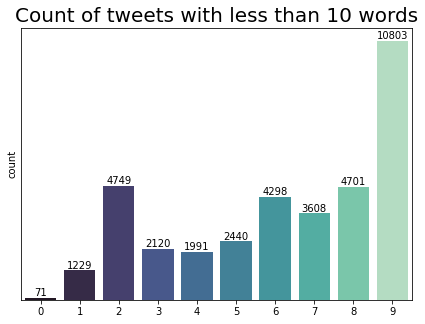

In [18]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=data[data['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [19]:
data = data[data['text_len'] > 3]

In [20]:
#data.sort_values(by=['text_len'], ascending=False)

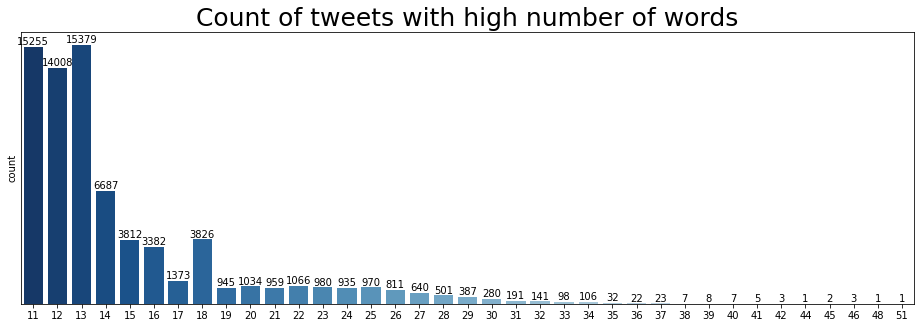

In [21]:

plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=data[(data['text_len']<=1000) & (data['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [22]:
max_len = np.max(data['text_len'])
max_len 

51

In [23]:
len(data)

111047

In [24]:
data.to_csv('merged_len_and_cleaned_130000.csv')

In [9]:
labels = []
for sent in data.sentiment:
    if sent == 0:
        label = '0'
    elif sent > 0 and sent <= 1:
        label = '1'
    elif sent >= -1 and sent <0:
        label = '-1'
    labels.append(label)

In [10]:
data['labels'] = labels
data.head()

,ID,text,sentiment,text_cleaned,text_len,labels
0,1629275091325583362,RT @PoliticalMoons2: These two recent articles...,0.18750,two recent articl discuss h5n1 bird flu detail...,14,1
2,1629275094294884352,RT @hcasan0va: These people have lost their mi...,-0.15625,peopl lost mind bc there global org perspect d...,12,-1
3,1629275094735372289,"RT @VigilantFox: Shedding Concerns: ""It Looks ...",0.00000,shed concern look like mrna transfer vaccin un...,11,0
5,1629275098308902912,"RT @VigilantFox: Ed Dowd: ""This Has Been a War...",0.10000,ed dowd war peopl die covid vaccin death earli...,12,1
6,1629275098451509250,RT @porta_janet: @VigilantFox @DrKStillwagon T...,0.00000,vaccin brought covid covid brought vaccin,6,0


# Machine Learning models

In [15]:
data = pd.read_csv('C:\\Users\\mamai\\Desktop\\Tesi\\Code\\notebookFinaliprove\\merged_len_sent_and_cleaned_130000.csv')
data.head()

,ID,text,sentiment,text_cleaned,text_len,labels
0,1629275091325583362,RT @PoliticalMoons2: These two recent articles...,0.18750,two recent articl discuss h5n1 bird flu detail...,14,1
1,1629275094294884352,RT @hcasan0va: These people have lost their mi...,-0.15625,peopl lost mind bc there global org perspect d...,12,-1
2,1629275094735372289,"RT @VigilantFox: Shedding Concerns: ""It Looks ...",0.00000,shed concern look like mrna transfer vaccin un...,11,0
3,1629275098308902912,"RT @VigilantFox: Ed Dowd: ""This Has Been a War...",0.10000,ed dowd war peopl die covid vaccin death earli...,12,1
4,1629275098451509250,RT @porta_janet: @VigilantFox @DrKStillwagon T...,0.00000,vaccin brought covid covid brought vaccin,6,0


In [16]:
max_len=np.max(data.text_len)
max_len

51

In [17]:
X = data['text_cleaned']
y = data['labels']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=seed_value)

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [20]:
X_train.head()

17176     dr pierr gilbewarn 1995 magnet vaccin rwanda o...
21723     gop exsen inhof retir due long covid oppos cov...
107595    fda cdc ever awar unpublic health risk associ ...
30860     start tomorrow auction almost everyth everyth ...
52207     shock 625000 increas myocard sinc vaccin rollo...
Name: text_cleaned, dtype: object

In [21]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [22]:
#sparse matrix, ogni colonna è una parola e ogni riga un tweet, nei valuea abbiamo quante volte compare la parola nl tweet

In [23]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [24]:
# sparse matrix (dovrebbe essere riaggiustata con la frequenza delle parole o boh)

# Naive Bayes

In [20]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [21]:
nb_pred = nb_clf.predict(X_test_tf)
nb_pred

array([ 1,  1,  0, ...,  1, -1,  0], dtype=int64)

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

          -1       0.90      0.73      0.80     12894
           0       0.89      0.76      0.82     14411
           1       0.74      0.94      0.82     17114

    accuracy                           0.82     44419
   macro avg       0.84      0.81      0.82     44419
weighted avg       0.83      0.82      0.82     44419



In [23]:
conf = confusion_matrix(y_test,nb_pred)
print(conf)

[[ 9366   690  2838]
 [  592 10908  2911]
 [  481   631 16002]]


In [24]:
conf_df = pd.DataFrame(data=conf, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'], 
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<AxesSubplot:>

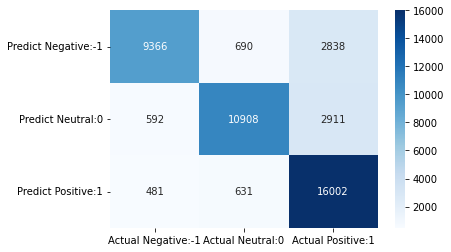

In [25]:
sns.heatmap(conf_df, annot = True, fmt = '', cmap = 'Blues')

In [26]:
#y_test

In [27]:
import collections
c = collections.Counter(y_test)
print(c)

Counter({1: 17114, 0: 14411, -1: 12894})


# Logistic regression

In [28]:
#Initial Bag of Words
bow_counts = CountVectorizer(
    tokenizer=word_tokenize
)
X_train_bow =  bow_counts.fit_transform(X_train)
X_test_bow = bow_counts.transform(X_test)

In [29]:
y_train_bow = y_train
y_test_bow = y_test

In [30]:
# Logistic regression
model1 = LogisticRegression(C=1, solver="liblinear",max_iter=200)
model1.fit(X_train_bow, y_train_bow)
# Prediction
test_pred = model1.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow, test_pred) * 100)

Accuracy:  92.24656115626196


In [31]:
print('Classification Report for Logistic Regression:\n',classification_report(y_test, test_pred))

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

          -1       0.93      0.89      0.91     12894
           0       0.91      0.95      0.93     14411
           1       0.93      0.92      0.93     17114

    accuracy                           0.92     44419
   macro avg       0.92      0.92      0.92     44419
weighted avg       0.92      0.92      0.92     44419



In [32]:
conf_log = confusion_matrix(y_test,test_pred)
print(conf_log)

[[11536   610   748]
 [  320 13679   412]
 [  611   743 15760]]


In [33]:
conf_df_log = pd.DataFrame(data=conf_log, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'], 
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<AxesSubplot:>

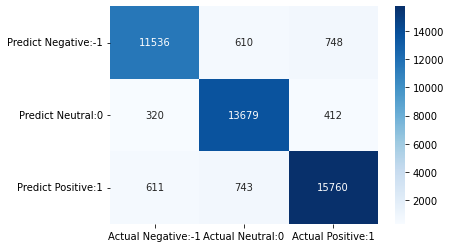

In [34]:
sns.heatmap(conf_df_log, annot = True, fmt = '', cmap = 'Blues')

# Random Forest

In [31]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_tf,y_train)

RandomForestClassifier()

In [32]:
rf_pred = rf_clf.predict(X_test_tf)
rf_pred

array([ 1,  1,  0, ..., -1, -1, -1], dtype=int64)

In [33]:
print('Classification Report for Random Forest:\n',classification_report(y_test, rf_pred))

Classification Report for Random Forest:
               precision    recall  f1-score   support

          -1       0.96      0.87      0.91      9671
           0       0.90      0.97      0.94     10808
           1       0.93      0.93      0.93     12836

    accuracy                           0.93     33315
   macro avg       0.93      0.93      0.93     33315
weighted avg       0.93      0.93      0.93     33315



In [34]:
conf_rf = confusion_matrix(y_test,rf_pred)
print(conf_rf)

[[ 8435   531   705]
 [   57 10525   226]
 [  290   576 11970]]


In [35]:
conf_df_rf = pd.DataFrame(data=conf_rf, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'], 
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<AxesSubplot:>

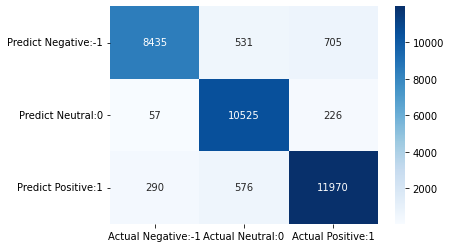

In [36]:
sns.heatmap(conf_df_rf, annot = True, fmt = '', cmap = 'Blues')

# SVM

In [37]:
#long time to train!

In [38]:
svm_clf=SVC()
svm_clf.fit(X_train_tf,y_train)

SVC()

In [39]:
svm_pred=svm_clf.predict(X_test_tf)
svm_pred

array([ 1,  1,  0, ...,  1, -1, -1], dtype=int64)

In [40]:
print('Classification Report for SVM:\n',classification_report(y_test, svm_pred))

Classification Report for SVM:
               precision    recall  f1-score   support

          -1       0.95      0.89      0.92      9671
           0       0.92      0.96      0.94     10808
           1       0.93      0.94      0.94     12836

    accuracy                           0.93     33315
   macro avg       0.93      0.93      0.93     33315
weighted avg       0.93      0.93      0.93     33315



In [41]:
conf_svm = confusion_matrix(y_test,svm_pred)
print(conf_svm)

[[ 8642   464   565]
 [  114 10403   291]
 [  313   472 12051]]


In [42]:
conf_df_svm = pd.DataFrame(data=conf_svm, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'], 
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<AxesSubplot:>

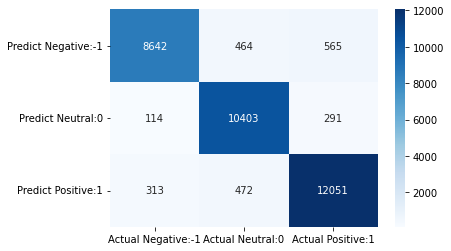

In [43]:
sns.heatmap(conf_df_svm, annot = True, fmt = '', cmap = 'Blues')

# Conclusion ML models

As expected, Naive Bayes was the model with the worst performances.
Regarding the other metrics, precision, recall and f1-score, SVM and Random Forest performed better than LR.

# Deep learning

Partiamo dall' inizio, prendiamo i dati e rifacciamo lo splitting del dataset dopo averli tokenizzati.
Per semplicità (dobbiamo creare un vocabolario quindi dobbiamo tokenizzare train e test insieme)

In [25]:
X = data['text_cleaned']
y = data['labels'].values

In [26]:
print(X[0])
print(y[0])
print(y)

two recent articl discuss h5n1 bird flu detail first delin accur 8month old project
1
[ 1 -1  0 ...  1 -1  1]


In [27]:
from collections import Counter

def Tokenize(column, seq_len):
    
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus) #Counter method counts all the words in the corpus, dictionary with word and number of times 
    sorted_words = count_words.most_common()  #list
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}  #Transform the words into numbers enumerating: first word is the one that occurs most time. 

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
        
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [28]:
vocabulary, tokenized_column = Tokenize(X, max_len)

In [29]:
vocabulary[:15]

[('covid', 35279),
 ('vaccin', 28336),
 ('pandem', 12706),
 ('amp', 12463),
 ('peopl', 11250),
 ('new', 9653),
 ('covid19', 8928),
 ('death', 8115),
 ('increas', 6896),
 ('like', 6517),
 ('still', 6280),
 ('work', 6220),
 ('get', 6205),
 ('biden', 5662),
 ('caus', 5480)]

In [30]:
print(X[0])
print(tokenized_column[0])
print(y[0])

two recent articl discuss h5n1 bird flu detail first delin accur 8month old project
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  160  694  632  460 1065
  787  154  674  106 9741 2240 8868  329 1025]
1


In [31]:
# https://tomaxent.com/2017/11/21/A-Simple-Multi-Class-Classification-Task-Keras-and-Scikit-Learn/
# 

from keras.utils import to_categorical
one_hot_encode_y = to_categorical(y, num_classes = 3)
print(one_hot_encode_y[:10])
#print(y[:10])

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [32]:
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(tokenized_column, one_hot_encode_y, test_size=0.4, stratify=one_hot_encode_y, random_state=seed_value)
X_train_dl, X_valid_dl, y_train_dl, y_valid_dl = train_test_split(X_train_dl, y_train_dl, test_size=0.2, stratify=y_train_dl, random_state=seed_value)

In [33]:
y_train_dl

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [34]:
y_test_dl

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [35]:
y_valid_dl

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [36]:
# Parameters

input_dim = len(vocabulary)+1 # +1 is for the padding

# Hyperparameters

embedding_dim = 64
hidden_dim = 32
drop_prob = 0.3
lr = 0.05
clipnorm_value = 1.

## RNN

In [41]:
# Keras Model

from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

import tensorflow.keras.metrics

from tensorflow.keras.callbacks import ModelCheckpoint


In [67]:

model_keras_rnn = Sequential([
  Embedding(input_dim, embedding_dim),
  SimpleRNN(hidden_dim, recurrent_dropout = 0.2, dropout = 0.2),
  Dropout(drop_prob),
  Dense(3, activation="sigmoid")  # 3 outputs, since we have 3 categories
])

#opt_adam = Adam(clipnorm=1, learning_rate = 0.05)

opt_sgd = SGD(learning_rate=lr, clipnorm=clipnorm_value)

model_keras_rnn.compile(optimizer=opt_sgd, loss='categorical_crossentropy', metrics=["accuracy", "Precision", "Recall"])  #categorical (not binary)
model_keras_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          2169600   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,172,803
Trainable params: 2,172,803
Non-trainable params: 0
_________________________________________________________________


### Training

In [68]:
epochs = 60
batch_size = 32

In [69]:

PATH_KERAS_RNN = 'C:\\Users\\mamai\\Desktop\\Tesi\\Code\\Models\\Keras\\RNN\\Simplified_Train60Test40Valid20\\'

# Model weights are saved at the end of every epoch, if it's the best seen so far.
model_checkpoint_callback = ModelCheckpoint(
    filepath=PATH_KERAS_RNN,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model_keras_rnn.fit(x=X_train_dl, y=y_train_dl,
        batch_size=batch_size, epochs=epochs,
        validation_data=(X_valid_dl, y_valid_dl),
        callbacks=[model_checkpoint_callback])

history

Epoch 1/60
1666/1666 [==============================] - 36s 19ms/step - loss: 0.8480 - accuracy: 0.5909 - precision: 0.5050 - recall: 0.7095 - val_loss: 0.6184 - val_accuracy: 0.7340 - val_precision: 0.6257 - val_recall: 0.8281
Epoch 2/60
1666/1666 [==============================] - 43s 26ms/step - loss: 0.5747 - accuracy: 0.7574 - precision: 0.6467 - recall: 0.8449 - val_loss: 0.4723 - val_accuracy: 0.8053 - val_precision: 0.7165 - val_recall: 0.8706
Epoch 3/60
1666/1666 [==============================] - 39s 23ms/step - loss: 0.4671 - accuracy: 0.8126 - precision: 0.6911 - recall: 0.8905 - val_loss: 0.3962 - val_accuracy: 0.8411 - val_precision: 0.7317 - val_recall: 0.9090
Epoch 4/60
1666/1666 [==============================] - 32s 19ms/step - loss: 0.3998 - accuracy: 0.8439 - precision: 0.7151 - recall: 0.9176 - val_loss: 0.3565 - val_accuracy: 0.8592 - val_precision: 0.7730 - val_recall: 0.9196
Epoch 5/60
1666/1666 [==============================] - 35s 21ms/step - loss: 0.3467 - a

In [70]:
# The model weights (that are considered the best) are loaded into the model.
model_keras_rnn.load_weights(PATH_KERAS_RNN)

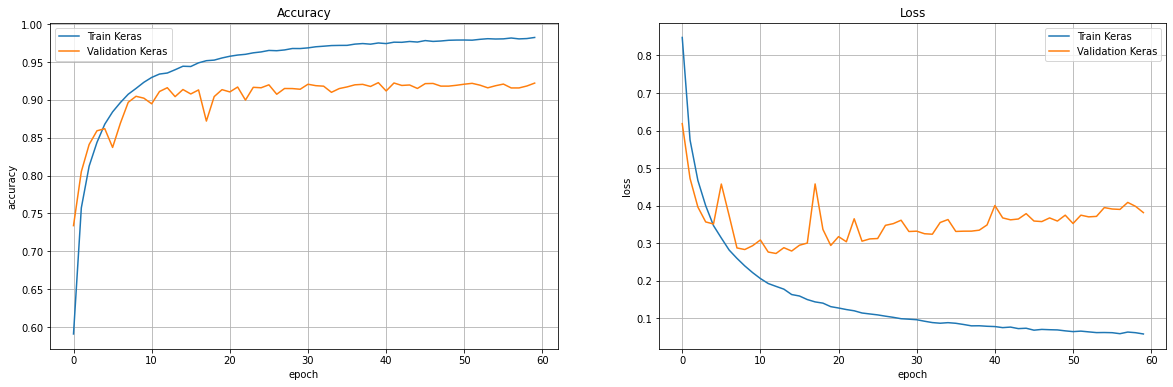

In [71]:
# Visualize results of Keras model

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Keras')
plt.plot(history.history['val_accuracy'], label='Validation Keras')
plt.title("Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Keras')
plt.plot(history.history['val_loss'], label='Validation Keras')
plt.title("Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.show()

In [72]:
model_keras_rnn.evaluate(X_test_dl, y_test_dl, verbose=2)

1389/1389 - 12s - loss: 0.3520 - accuracy: 0.9212 - precision: 0.8563 - recall: 0.9505 - 12s/epoch - 9ms/step


[0.3519522547721863, 0.92118239402771, 0.8563084602355957, 0.9505391716957092]

## LSTM

In [46]:
# Hyperparameters
batch_size=32
epochs=60

embedding_dim = 64
hidden_dim = 32
drop_prob = 0.3
lr = 0.05
clipnorm_value = 1.

In [39]:
from tensorflow.keras.layers import Bidirectional, LSTM

model_keras_lstm = Sequential([
  Embedding(input_dim, embedding_dim),
  LSTM(hidden_dim, recurrent_dropout = 0.2, dropout = 0.2),   
  Dropout(drop_prob),
  Dense(3, activation="sigmoid")
])

#opt_adam = Adam(clipnorm=1, learning_rate = 0.05)

opt_sgd = SGD(learning_rate=lr, clipnorm=clipnorm_value)

model_keras_lstm.compile(optimizer=opt_sgd, loss='categorical_crossentropy', metrics=["accuracy", "Precision", "Recall" ])
model_keras_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          2169600   
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 2,182,115
Trainable params: 2,182,115
Non-trainable params: 0
_________________________________________________________________


In [ ]:
PATH_KERAS_LSTM = 'C:\\Users\\mamai\\Desktop\\Tesi\\Code\\Models\\Keras\\LSTM\\Simplified_Train60Test40Valid20\\'

# Model weights are saved at the end of every epoch, if it's the best seen so far.
model_checkpoint_callback = ModelCheckpoint(
    filepath=PATH_KERAS_LSTM,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model_keras_lstm.fit(x=X_train_dl, y=y_train_dl,
        batch_size=batch_size, epochs=epochs,
        validation_data=(X_valid_dl, y_valid_dl),
        callbacks=[model_checkpoint_callback])

history

Epoch 1/60
1666/1666 [==============================] - 58s 33ms/step - loss: 1.0087 - accuracy: 0.4859 - precision: 0.4453 - recall: 0.6301 - val_loss: 0.7966 - val_accuracy: 0.6500 - val_precision: 0.5291 - val_recall: 0.8176
Epoch 2/60
1666/1666 [==============================] - 60s 36ms/step - loss: 0.5968 - accuracy: 0.7528 - precision: 0.6202 - recall: 0.8679 - val_loss: 0.4942 - val_accuracy: 0.7939 - val_precision: 0.6967 - val_recall: 0.8775
Epoch 3/60
1666/1666 [==============================] - 60s 36ms/step - loss: 0.4078 - accuracy: 0.8438 - precision: 0.7096 - recall: 0.9206 - val_loss: 0.3828 - val_accuracy: 0.8517 - val_precision: 0.7451 - val_recall: 0.9175
Epoch 4/60
1666/1666 [==============================] - 60s 36ms/step - loss: 0.3262 - accuracy: 0.8813 - precision: 0.7541 - recall: 0.9416 - val_loss: 0.3201 - val_accuracy: 0.8820 - val_precision: 0.7727 - val_recall: 0.9388
Epoch 5/60
1666/1666 [==============================] - 61s 36ms/step - loss: 0.2766 - a

In [77]:
# The model weights (that are considered the best) are loaded into the model.
# The best model is the one that achieves the smaller loss on the validation set.
model_keras_lstm.load_weights(PATH_KERAS_LSTM)

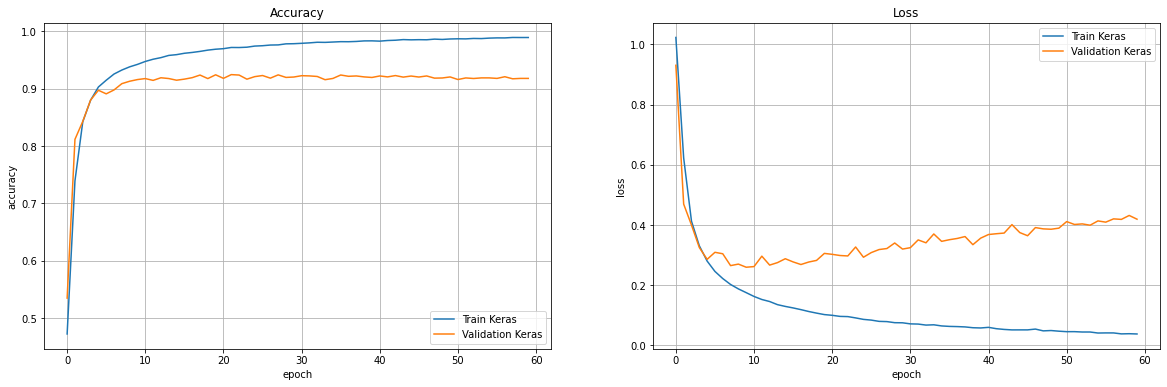

In [78]:
# Visualize results of Keras model

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Keras')
plt.plot(history.history['val_accuracy'], label='Validation Keras')
plt.title("Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Keras')
plt.plot(history.history['val_loss'], label='Validation Keras')
plt.title("Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.show()

In [79]:
model_keras_lstm.evaluate(X_test_dl, y_test_dl, verbose=2)

1389/1389 - 9s - loss: 0.3048 - accuracy: 0.9231 - 9s/epoch - 6ms/step


[0.3048495948314667, 0.9230509400367737]

# Conclusion Neural Networks


0.3519522547721863, 0.92118239402771, 0.8563084602355957, 0.9505391716957092

In [31]:
epochs = 80

In [34]:
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

embedding_dim = 64
hidden_dim = 32
drop_prob = 0.3
lr = 0.05
clipnorm_value = 1.
input_dim = len(vocabulary)+1 # +1 is for the padding


model_keras_lstm_1 = Sequential([
  Embedding(input_dim, embedding_dim),
  LSTM(hidden_dim, dropout = drop_prob, recurrent_dropout= drop_prob),#, dropout = 0.2)),  
  Dropout(drop_prob),
  Dense(3, activation="sigmoid")
])

#opt_adam = Adam(clipnorm=1, learning_rate = 0.05)

opt_sgd = SGD(learning_rate=lr, clipnorm=clipnorm_value)

model_keras_lstm_1.compile(optimizer=opt_sgd, loss='categorical_crossentropy', metrics=["accuracy"])
model_keras_lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1296640   
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 1,309,155
Trainable params: 1,309,155
Non-trainable params: 0
_________________________________________________________________


In [37]:
PATH_KERAS_LSTM = 'C:\\Users\\mamai\\Desktop\\Tesi\\Code\\Models\\Keras\\LSTM\\'

from tensorflow.keras.callbacks import ModelCheckpoint
batch_size=32

# Model weights are saved at the end of every epoch, if it's the best seen so far.
model_checkpoint_callback = ModelCheckpoint(
    filepath=PATH_KERAS_LSTM,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

history = model_keras_lstm_1.fit(x=X_train_dl, y=y_train_dl,
        batch_size=batch_size, epochs=epochs,
        validation_data=(X_valid_dl, y_valid_dl),
        callbacks=[model_checkpoint_callback])

history

Epoch 1/80
963/963 [==============================] - 59s 55ms/step - loss: 1.0699 - accuracy: 0.4209 - val_loss: 1.0088 - val_accuracy: 0.5004
Epoch 2/80
963/963 [==============================] - 51s 53ms/step - loss: 0.8811 - accuracy: 0.5868 - val_loss: 0.7305 - val_accuracy: 0.6767
Epoch 3/80
963/963 [==============================] - 51s 53ms/step - loss: 0.6009 - accuracy: 0.7493 - val_loss: 0.5186 - val_accuracy: 0.7843
Epoch 4/80
963/963 [==============================] - 52s 53ms/step - loss: 0.4674 - accuracy: 0.8159 - val_loss: 0.4258 - val_accuracy: 0.8305
Epoch 5/80
963/963 [==============================] - 51s 53ms/step - loss: 0.3842 - accuracy: 0.8561 - val_loss: 0.3968 - val_accuracy: 0.8460
Epoch 6/80
963/963 [==============================] - 1237s 1s/step - loss: 0.3280 - accuracy: 0.8791 - val_loss: 0.3520 - val_accuracy: 0.8720
Epoch 7/80
963/963 [==============================] - 52s 54ms/step - loss: 0.2878 - accuracy: 0.8963 - val_loss: 0.3341 - val_accuracy:

In [38]:
# The model weights (that are considered the best) are loaded into the model.
# The best model is the one that achieves the smaller loss on the validation set.
model_keras_lstm_1.load_weights(PATH_KERAS_LSTM)

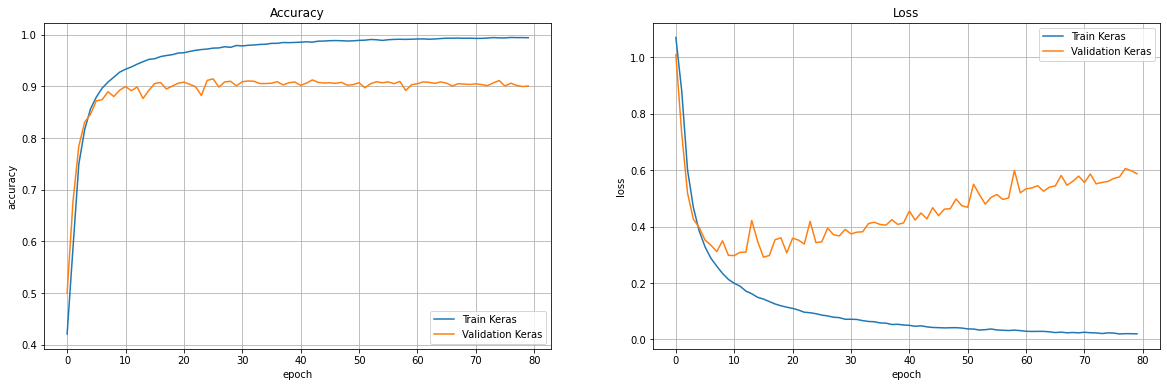

In [39]:
# Visualize results of Keras model

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Keras')
plt.plot(history.history['val_accuracy'], label='Validation Keras')
plt.title("Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Keras')
plt.plot(history.history['val_loss'], label='Validation Keras')
plt.title("Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.show()

In [40]:
model_keras_lstm_1.evaluate(X_test_dl, y_test_dl, verbose=2)

268/268 - 1s - loss: 0.5983 - accuracy: 0.9051 - 1s/epoch - 5ms/step


[0.5982987284660339, 0.9050625562667847]